In [1]:
import math
import os.path as op
from ast import literal_eval
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

In [2]:

def plot_radar(corrs, features, model, out_fig):
    n_rows = 10
    angle_zero = 0
    fontsize = 36
    
    corrs = corrs[:n_rows]
    features = features[:n_rows]
    angles = [(angle_zero + (n / float(n_rows) * 2 * np.pi)) for n in range(n_rows)]
    if model == "lda" or model == "gclda":
        features = ["\n".join(feature.split("_")[1:]) for feature in features]

    roundup_corr = math.ceil(corrs.max() * 10) / 10

    # Define color scheme
    plt.rcParams["text.color"] = "#1f1f1f"
    cmap = cm.get_cmap("YlOrRd")
    norm = plt.Normalize(vmin=corrs.min(), vmax=corrs.max())
    colors = cmap(norm(corrs))

    # Plot radar
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "polar"})
    ax.set_theta_offset(0)
    ax.set_ylim(-0.1, roundup_corr)

    ax.bar(angles, corrs, color=colors, alpha=0.9, width=0.52, zorder=10)  

    # color=GREY12
    ax.vlines(angles, 0, roundup_corr, color="grey", ls=(0, (4, 4)), zorder=11)

    ax.set_xticks(angles)
    ax.set_xticklabels(features, size=fontsize)

    ax.xaxis.grid(False)

    step = 0.1
    yticks = np.round(np.arange(0, roundup_corr + step, step), 1)
    ax.set_yticklabels([])
    ax.set_yticks(yticks)

    ax.spines["start"].set_color("none")
    ax.spines["polar"].set_color("none")

    xticks = ax.xaxis.get_major_ticks()
    [xtick.set_pad(70) for xtick in xticks]

    sep = 0.06
    [
        ax.text(np.pi / 2, ytick - sep, f"{ytick}", ha="center", size=fontsize-2, color="grey", zorder=12) 
        for ytick in yticks
    ]

    fig.savefig(out_fig, bbox_inches="tight")

In [3]:
from wordcloud import WordCloud

def plot_cloud(features_list, frequencies, corrs, model, out_fig):
    frequencies_dict = {}
    if model == "lda" or model == "gclda":
        for features, frequency_str, corr in zip(features_list, frequencies, corrs):
            frequency = literal_eval(frequency_str)
            for word, freq in zip(features, frequency):
                if word not in frequencies_dict:
                    frequencies_dict[word] = freq * corr
    else:
        for word, corr in zip(features_list, corrs):
            if word not in frequencies_dict:
                frequencies_dict[word] = corr
    
    fig, ax = plt.subplots(figsize=(9, 5))
    wc = WordCloud(background_color="white", random_state=0, colormap="YlOrRd")
    wc.generate_from_frequencies(frequencies=frequencies_dict)
    ax.imshow(wc)
    ax.axis("off")
    fig.savefig(out_fig, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


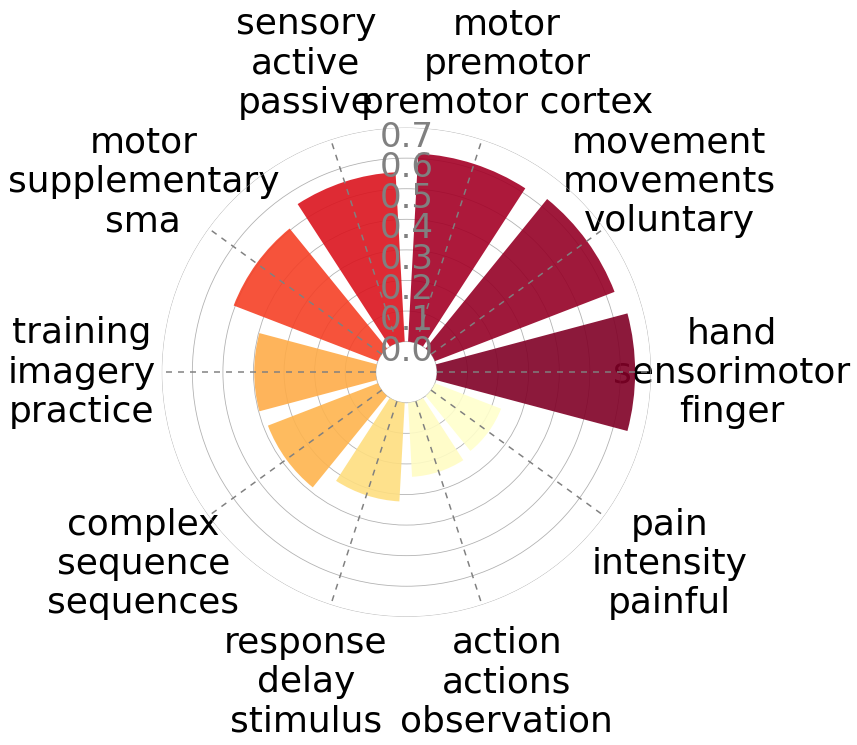

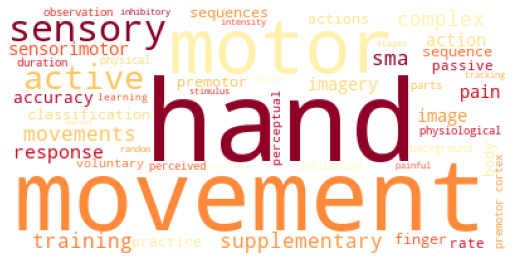

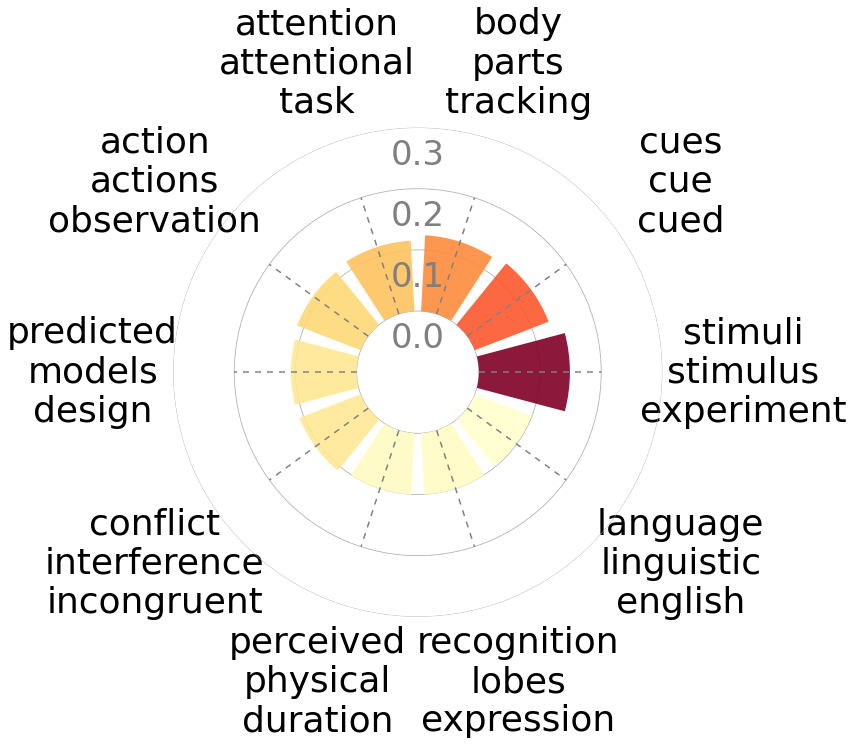

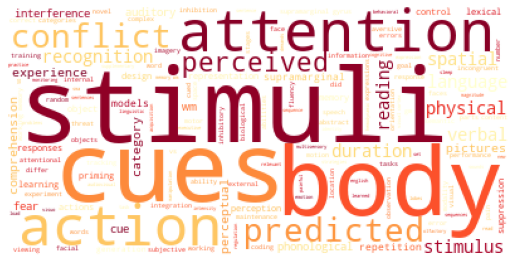

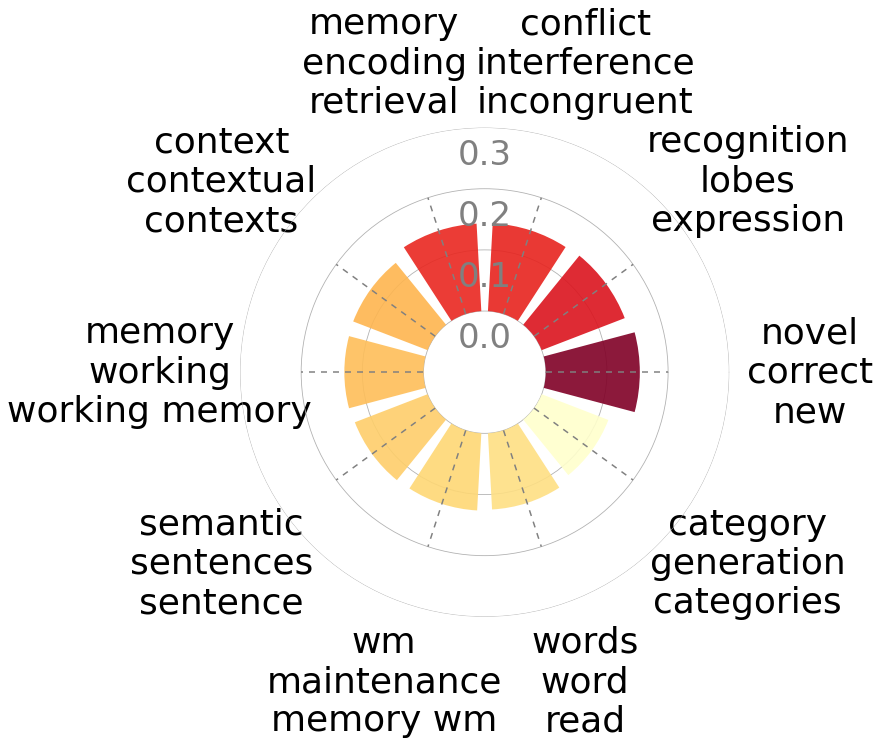

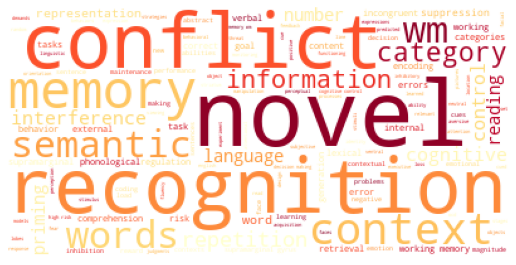

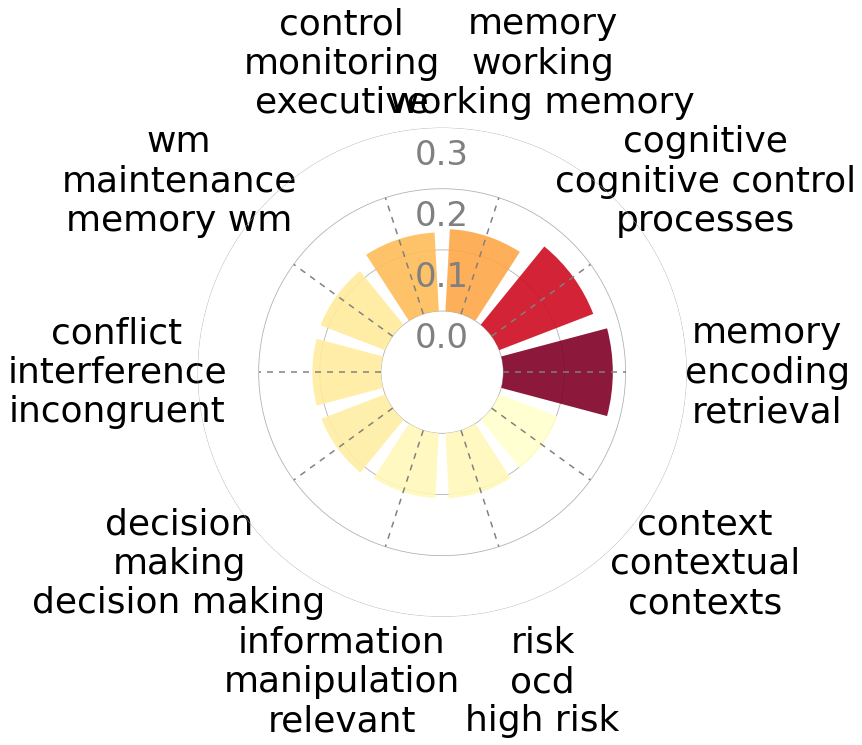

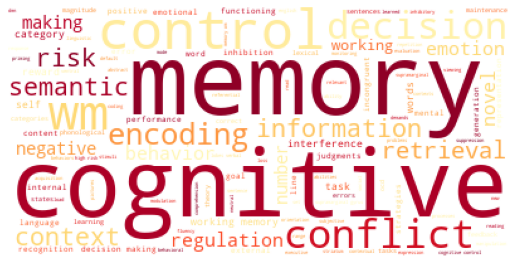

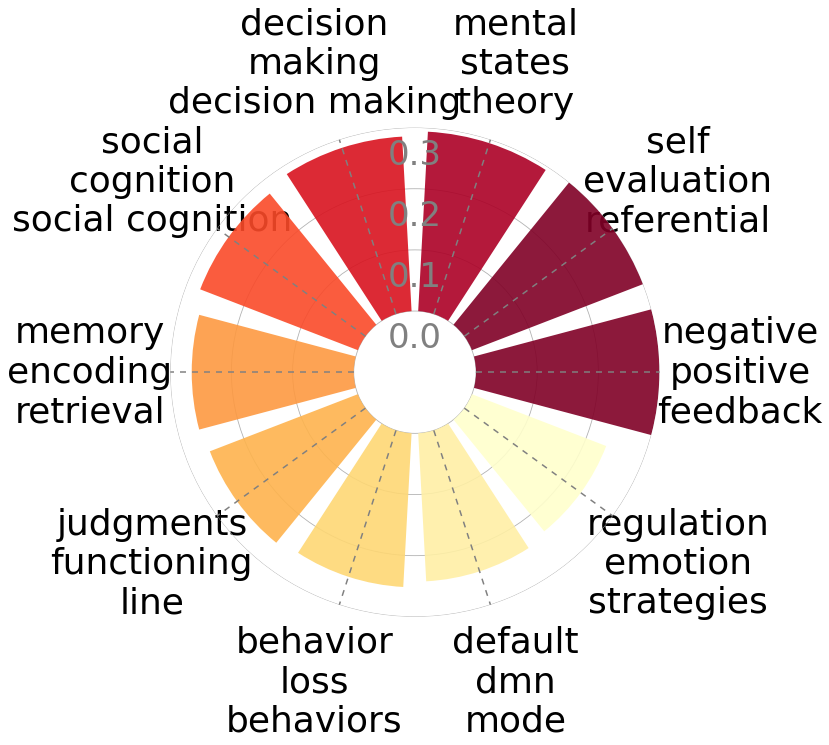

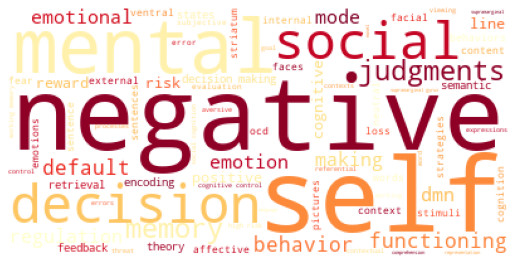

In [4]:
# methods = ["Percentile", "KMeans", "KDE"]
# dset_names = ["neurosynth", "neuroquery"]
# models = ["term", "lda", "gclda"]

methods = ["KMeans"]
dset_names = ["neurosynth"]
models = ["lda"]

segmentations = ["05"]
seg_sols = ["01", "02", "03", "04", "05"]

for model, method, dset_name in itertools.product(models, methods, dset_names):
    corr_dir = op.join("../results/decoding", f"{model}_{dset_name}_corr_{method}")
    for seg in segmentations:
        for seg_sol in seg_sols:
            data_df = pd.read_csv(op.join(corr_dir, f"{seg}-{seg_sol}.tsv"), sep="\t", index_col=None)
                    
            data_df = data_df.rename(columns={ data_df.columns[0]: "index" })
            filtered_df = data_df.query('corr > 0 & pval < 0.05 & classification == "Functional"')
            filtered_df = filtered_df.sort_values(by=['corr'], ascending=False)

            # Data for radar plot
            corrs = filtered_df["corr"].values
            features = filtered_df["feature"].values

            # Data for wordcloud
            if model == "lda" or model == "gclda":
                features_split = [feature.split("_")[1:] for feature in features]
                frequencies = filtered_df["frequencies"].values.tolist()
            else:
                features_split = features
                frequencies = None

            radar_fn = op.join("./Fig", "survey", f"radar_{model}-{dset_name}-{method}_{seg}-{seg_sol}.eps")
            cloud_fn = op.join("./Fig", "survey", f"cloud_{model}-{dset_name}-{method}_{seg}-{seg_sol}.eps")
            plot_radar(corrs, features, model, radar_fn)
            plot_cloud(features_split, frequencies, corrs, model, cloud_fn)